# m2vDroid: Perturbation-resilient metapath-based Android Malware Detection

## INTRODUCTION

Over the past decade, malware has established itself as a constant issue for the Android operating system. In 2018, Symantec reported that they blocked more than 10 thousand malicious Android apps per day, while nearly 3 quarters of Android devices remained on older versions of Android. With billions active Android devices, millions are only a swipe away from becoming victims. Naturally, automated machine learning-based detection systems have become commonplace solutions as they can drastically speed up the labeling process. However, it has been shown that many of these models are vulnerable to adversarial attacks, notably attacks that add redundant code to malware to consfuse detectors. 

First, we introduce a new model that extends the [Hindroid detection system](https://www.cse.ust.hk/~yqsong/papers/2017-KDD-HINDROID.pdf) by employing node embeddings using [metapath2vec](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf) which we call m2vDroid. We believe that the introduction of node embeddings will improve the performance of the model beyond the capabilities of HinDroid. Second, we intend to break these two models using a method similar to that proposed in  the [Android HIV paper](https://ieeexplore.ieee.org/document/8782574). That is we train an adversarial model that perturbs malware such that a detector mislabels it as a benign app. We then measure the performance of each model after recursively feeding adversarial examples back into them. We believe that by doing so, our model will be able outperform the Hindroid implementation in its ability to label malware even after adversarial examples have been added.

## PREVIOUS WORKS
### Hindroid
Hindroid is a malware detection system developed in 2017 by Hou, et al and is a significant inspriation for our model, m2vDroid. In it, they "represent Android apps, related APIs, and their rich relations as a hereogeneous information network" and was one of the firsts to apply this method for the detection of malware. To build their heterogeneous information network, they unpack and decompile Android apps into the readable `smali` format and extract information for each API call (Notably, their code block, package, and invoke method). With this data, they construct 4 matrices which serve as adjacency matrices for Apps and APIs in the heterogeneous information network:

<table>
    <tr>
        <th colspan=3> <b>Description of Each Matrix</b></th>
    </tr>
    <tr>
        <th><b>G</b></th>
        <th>Element</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><b>A</b></td>
        <td> $a_{i,j}$ </td>
        <td> If $app_i$ contains $API_j$, then $a_{i,j} = 1$;<br> otherwise, $a_{i,j} = 0$.</td>
    </tr>
    <tr>
        <td><b>B</b></td>
        <td> $b_{i,j}$ </td>
        <td> If $API_i$ and $API_j$ co-exist in the same block, then $b_{i,j} = 1$;<br> otherwise, $b_{i,j} = 0$.</td>
    </tr>
    <tr>
        <td><b>P</b></td>
        <td> $p_{i,j}$ </td>
        <td> If $API_i$ and $API_j$ have the same package name, then $p_{i,j} = 1$;<br> otherwise, $p_{i,j} = 0$.</td>
    </tr>
    <tr>
        <td><b>I</b></td>
        <td> $i_{i,j}$ </td>
        <td> If $API_i$ and $API_j$ have the same invocation type, then $i_{i,j} = 1$;<br> otherwise, $i_{i,j} = 0$.</td>
    </tr>
</table>

Using these relationships, they form metapaths between all apps. For example, the metapath $App \xrightarrow{contains}API\xrightarrow{contains^{-1}}App$ which is captured by the $AA^T$ kernel. Other kernels they consider include $ABA^T$, $APA^T$, $ABPB^TA^T$, and $APBP^TA^T$. For $n$ apps, this produces $n \times n$ matrices — for each metapath — where the value at index $[i,j]$ is the number of paths connecting $App_i$ with $App_j$ for that metapath. Therefore, each row in the matrix is the feature vector for an app with the number of metapaths between it and all other apps in the training set. Each matrix then forms a kernel for a support vector machine and with multi-kernel learning they were able to achieve performances ranging from a $0.948$ F1-score to $0.988$ with the multi-kernel model.

### Android HIV
In this paper, the authors, Chen et al., introduce a framework for attacking malware detection models, specifically the MamaDroid and Drebin systems. To perform this, they modified two adversarial attack algorithms: a modified Carlini and Wagner (C&W) attack and a modified Jacobian Saliency Map Attack (JSMA). These modified algorithms were used to generate perturbations that were added into the features of an apps so that they were misclassified as benign all while keeping the app(s) as functional examples of malware. With these methods, they were able to reduce the performance of both the MamaDroid and Drebin malware detection systems from detection rates of more than $95\%$ to $1\%$. In this paper, we adapt their methods in order to attack the HinDroid system and our model, m2vDroid.

## METHODOLOGY
First, we will describe the details of our proposed model, m2vDroid, and then we will describe the method we used to attack each model in the Adversarial Attack section.

## m2vDroid
m2vDroid is another malware detection model that we implemented that is largely based off HinDroid. However it uses node embeddings for the final vector representations of apps instead of the bag-of-APIs/commuting matrix solution that HinDroid applied.

### Preliminaries
There are a few concepts that we should introduce before we get into details:

- *Definition 1)* A **Heterogeneous Information Network (HIN)** is a graph in which its nodes and edges have diferent types. 

- *Definition 2)* A **Metapath** is a path within a HIN that follows certain node types. For example, let us define a HIN with a set of node types $T$ and a path $P = n_1 \longrightarrow n_2 \longrightarrow ... \longrightarrow n_{N}$ of length $N$. $P$ follows metapath $M_P = t_1 \longrightarrow t_2 \longrightarrow ... \longrightarrow t_{N}$ if $type(n_i) = t_i$ for all $i \in [1,2,...,N]$.

### Feature extraction
Our ETL pipeline begins with Android apps in the form of APK files. These APKs are unpacked using [Apktool](https://ibotpeaches.github.io/Apktool/) to reveal the contents of the app, but we are primarily concerned with `classes.dex`, the app's bytecode. We decompile the bytecode using [Smali](https://github.com/JesusFreke/smali) into readable `.smali` text files. From here we extract each API call, along with the app and method it appears in, and the package it is from. This is done for every API in an app and for every app in a dataset, forming a table with the the information needed for the next step.

### HIN Construction
Using the data extracted previously, we construct a heterogeneous information network using the [Stellargraph](https://github.com/stellargraph/stellargraph) library. Our HIN contains 4 types of nodes which we define as: 
- $Apps$: Android apps determined by name or md5, i.e. `com.microsoft.excel` or `09d347c6f4d7ec11b32083c0268cc570`.
- $APIs$: APIs determined by their smali representation, i.e. `Lpackage/Class;->method();V`
- $Packages$: the package an API originates from, i.e. `Lpackage`.
- $Methods$: Methods (or "functions") that API calls appear in, i.e. `LclassPackage/class/method();V`.

The distinct nodes for each type correspond to the distinct values of their column in the API data table described earlier. $Apps$ and $APIs$ share an edge if an $API$ is used within an $App$. Likewise with $APIs$ and $Methods$, they share an edge if a $Method$ contains an $API$. $Packages$ and $APIs$ share an edge if an $API$ orginates from a $Package$.

### Metapath2vec
To generate our features, we apply the metapath2vec algorithm on the $App$ nodes of our HIN. That is we 1) perform a random-walk starting from each app following designated metapaths to generate a corpus consisting of nodes in our HIN, then we 2) pass this corpus into the gensim implmentation of the [word2vec](https://arxiv.org/pdf/1301.3781.pdf) model to transform each $App$ into a vector.

After running this ETL on our data, we observed clear clustering after plotting a TSNE transformation. For the most, part it seems that this method is able to distinguish between not only malware and non-malware, but can also distinguish between different classes of malware to a reasonable extent. Notably, we have not tested the node2vec or metapath2vec++ algorithms for generating our random walk.

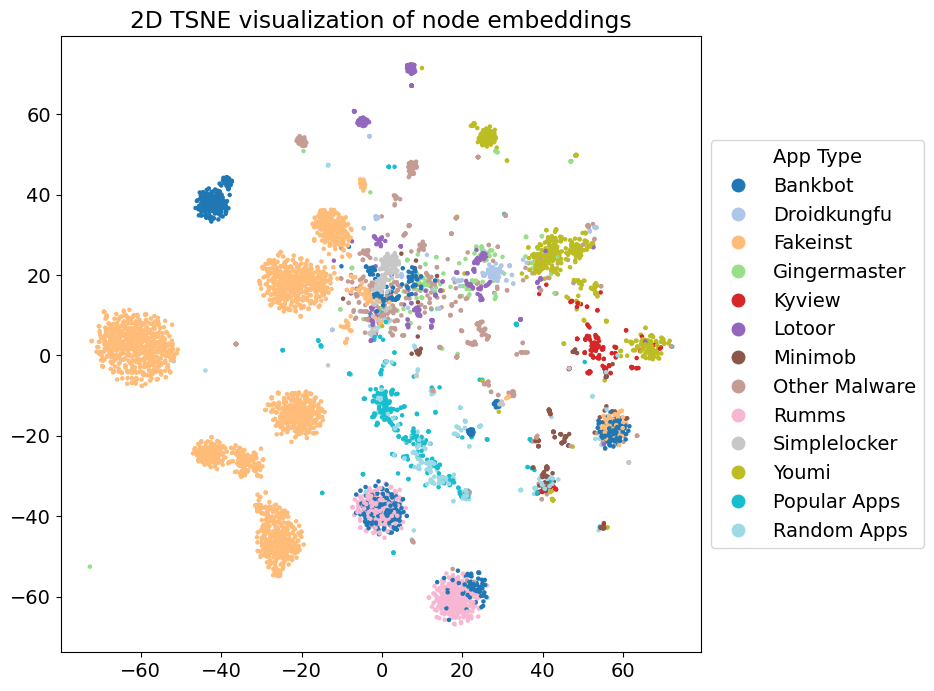

In [4]:
from IPython.display import Image, display, HTML

# display(HTML("""
# <style>
# .output {
#     display: flex;
#     align-items: center;
#     text-align: center;
# }

# .output_area {
#     display: flex;
#     align-items: center;
#     text-align: center;
# }
# .output_subarea {
#     max-width: 100% !important;
# }
# </style>
# """))
Image(filename="../data/out/all-apps/2D-plot.png")

Notes for cluster EDA, will be cleaned later:
- BankBot - Mobile banking trojan, "steals banking credentials and payment information. It tricks users into handing over their bank details by presenting an overlay window which looks identical to a bank's app login page." [Source](https://www.zdnet.com/article/bankbot-android-malware-sneaks-into-the-google-play-store-for-the-third-time/)
- RuMMs: Distributed via SMS phishing, sends info on user to remote server and spreads via their contacts. Also contacts financial institutions querying balances and in some cases initiating transactions. [Source](https://www.fireeye.com/blog/threat-research/2016/04/rumms-android-malware.html)
- FakeInst: Trojan that portrayed itself as an adult video viewer, but actually sends SMS to premium numbers
- Lotoor: Uses exploit to escalate privileges to an invader. [Source](https://www.f-secure.com/v-descs/exploit_android_gingerbreak.shtml)
- Minimob: Aggressive adware, no other details available.
- Youmi: Adware, also collects device information, downloads other apps. [Source](https://www.vice.com/en/article/9a399y/the-youmi-adware-that-plagued-ios-apps-also-affects-android)

Multiple FakeInst clusters: Variations of FakeInst attacks? There were "waves" essentially each with varying degrees of attacks.

It could be possible that BankBot and RuMMS are being clustered frequently since both are interested in banking information.

Not sure why BankBot and FakeInst have a cluster

***
## ADVERSARIAL ATTACK
Our adversarial attack follows many of the techniques applied by Chen, et al. 2018 to attack the MaMaDroid and Drebin models. To perform our adversarial attack, we simulated *Scenerio FB* with the following conditions: we have blackbox access to a malware classifier so we may query it to predict examples as they are generated and we also have access to the feature set with which to input into the classifier. The classifier may vary between m2vDroid and different kernels of HinDroid for initial benchmarks, but we will primarily use the m2vDroid classifier once we begin recursive training. The feature set will be the set of APIS derived from our training app set. The input vector will be the one-hot-encoded set of APIs for the example app. Our goal is to have the adversarial model add APIs to the example until it is misclassified or we reach a maximum. We want the app to retain its original function, so no APIs can be removed. Therefore, we modified the C&W attack from Android HIV to fit our application.

*To be expanded in the future...*

## EXPERIMENT
To test our models, we used a dataset of 5,840 apps. 5,516 of these apps have been deemed malicious through other methods. We will use this set the malware set. 324 apps were selected at random from the Popular category (We are looking into increasing this number). We believe the apps from this category would be unlikely to contain malware, so we treated them as a benign app set. Between these apps, there were 5,160,691 distinct API calls from 551,624 packages, contained in 5,517,770 distinct method declarations.

We will compare 5 of Hindroid's best performing single-kernel models ($AA^T$, $ABA^T$, $APA^T$, $ABPB^TA^T$, $APBP^TA^T$) against m2vDroid at 3 steps: 1) Before adversarial training, 2) After 1 round of adversarial training, 3) After being retrained on the adversarial examples generated from step 2.  

In step 1, we split the apps into train and test sets, training each model on the training set and evaluating their performance on the test set. At step 2, we select 10% of all malware from both the training set and the test set to generate adversarial examples using the trained m2vDroid model as the classifier. Breaking m2vDroid should in theory break the HinDroid models as they rely the same graph structure. We also believe that this should put our model at a disadvantage and further prove its efficacy. At Step 3, we retrain each model on the training set and evaluate on the test set, but with adversarial examples replacing their original apps.

### m2vDroid Parameters
For the metapath walk, we leveraged Stellargraph's `MetaPathRandomWalk` algorithm and specified a walk length of 60, walking on each of the following metapaths 3 times per $App$ node:
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Method$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Package$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Package$ $\rightarrow$ $Api$ $\rightarrow$ $Method$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Method$ $\rightarrow$ $Api$ $\rightarrow$ $Package$ $\rightarrow$ $Api$ $\rightarrow$ $App$

We chose these metapaths as they are similar to the set formed by the 5 single kernel models of HinDroid we will be considering.

For word2vec, we used a skip-gram model trained over 5 epochs. We used a window size of 7 so that 2 connected apps could appear in a window even in the longest metapaths and `min_count=0` so that all nodes in the metapath walk were incorporated. We were sure to include negative sampling as part of the process, as negative samples would help further distinguish nodes the are not associated with each other. For this we specified `negative=5` for a final output vector of length 128.

## RESULTS

### Baseline Model performance
The performance of each model is outlined below.
- Initial performance of models on normal data
- Performance after Android HIV trained on data
- Performance of models

Intial performance:

In [2]:
import pandas as pd
pd.read_csv('assets/baseline_performance_chart.csv', index_col=0).style.format({
    'f1': '{0:.3f}',
    'acc': '{0:.3f}',
    'rec': '{0:.3f}',
})

,f1,acc,rec,TP,TN,FP,FN
m2vDroid,0.992,0.985,1.000,2758,119,43,0
AAT,0.998,0.996,0.999,2754,153,9,4
ABAT,0.983,0.968,0.971,2679,149,13,79
APAT,0.994,0.988,0.998,2753,132,30,5
ABPBTAT,0.998,0.996,0.997,2750,157,5,8
APBPTAT,0.984,0.971,0.974,2687,148,14,71


## REFERENCES
TODO

## APPENDIX

### Original Proposal
The data that will be used to build our model is benign and malignant android applications, which
are then broken down into smali files. Our proposal is building the malware detection system that
was created from the HinDroid paper, which was a malware detection system that used the metapaths
generated from apps’ code to connect apps through the API calls they contain. Our proposal
would differ from simply recreating the model that was created in the HinDroid paper, as we would
instead use the metapath2vec to generate a final representation of our network that would then
be used to train our model on. The benefits of using metapath2vec instead of simply just using
HinDroid, which would allow us to use more sophisticated models, instead of the multi-kernel SVMs
that were used in HinDroid. From this point, we can then continue to improve the robustness of
our model by setting it against the Android HIV that perturbs the source code of malware that
makes it more difficult to detect. As a result, our new model would be able to detect the malware
even when we take Android HIV into consideration, which would make it harder for malware to
evade detection. The output of our project would be a model that would be able to determine
whether there is malware or not within an app based on the app, api calls, and codeblocks.

To set a baseline, we explored a sample of the apps we were given access to. We explored 150 apps,
75 known malicious apps and 75 popular apps we can presume benign. These apps tended to be
smaller and contained less API calls overall. Due to this disparity, we normalized the data by the
number of APIs each app contained.

| malware | apps | num_apis      | num_unique_apis |
|---------|------|---------------|-----------------|
| False   | 75   | 158266.933333 | 34913.093333    |
| True    | 75   | 15060.320000  | 3590.706667     |